In [1]:
#### TASK 1 AND 2 ARE IN THIS NOTEBOOK, i didn't saw a need to seperate it since you approved it on moodle (https://moodle.city.ac.uk/mod/forum/discuss.php?d=186126)
# Needs to pip install opencv-python and pillow
# The final graphs plus rendering the window were code from stack overflow, so the % of code from the web should be 10-15%
import numpy as np 
import matplotlib.pyplot as plt  
import warnings # Remove some warnings that aren't relevant
import cv2  # Live visual
import time  # using this to keep track of the saved Q-Tables.
from matplotlib import style  # Charts
from PIL import Image  # Visuals on the enviroment
import pickle  # to save/load Q-Tables

In [2]:
warnings.filterwarnings('ignore') # No warnings thanks.
style.use("ggplot") # Default style
INIT_QTABLE = None # Input of the Q table (OPTIONAL, example "qtable-1618124113.pickle")

# This is only used for the visual representation of the episodes!
AGENT_K = 1  # player key in dict
GOLD_K = 2  # gold key in dict
ENEMY_K = 3  # enemy key in dict
# Dictionary for colors. (They are in BGR! Given that this is using cv2) 
d = {1: (219, 112, 147), 2: (0, 255, 255), 3: (0, 0, 255)}
         # PURPLE               # YELLOW          # RED

ENVIROMENT_SIZE = 12 # ENVIROMENT_SIZE of the enviroment
MAXIMUM_EPISODES = 5000 # Number of episodes to simulate 
MOVE_PUNISHMENT = 1 # Penalty of the movement to the agent
ENEMY_PUNISHMENT = 300 # Penalty of the enemy to the agent
GOLD_REWARD = 50 # Reward of the gold to the agent
epsilon = 0.9 # Randomness (movement wise) for the agent to have
EPS_DECAY = 0.9998  # How fast the epsilon decay should happen
STOP_EVERY = 1000  # Show the enviroment episode after X. 
STEPS_ALLOWED = 500
LEARNING = 0.1 # Updating the Q values (0-1)
DISCOUNT = 0.95 # If it cares about future rewards or not (0-1)
STEPS_TAKEN = 0
STATS_EVERY = 100


In [3]:
class Agent:
    def __init__(self):
        self.x = np.random.randint(0, ENVIROMENT_SIZE)
        self.y = np.random.randint(0, ENVIROMENT_SIZE)

    def __str__(self):
        return f"{self.x}, {self.y}"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def action(self, choice):
        # Agent has 4 movement option to take (UP, DOWN, LEFT, RIGHT)
        if choice == 0:
            self.move(x=1, y=0)
        elif choice == 1:
            self.move(x=-0, y=-1)
        elif choice == 2:
            self.move(x=0, y=1)
        elif choice == 3:
            self.move(x=1, y=0)

    def move(self, y=False, x=False):

        # if there isn't a Y value, move at random
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y
        
        # if there isn't a X value, move at random
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If the agent gets outside of the enviroment, push him back in
        if self.x < 0:
            self.x = 0
        elif self.x > ENVIROMENT_SIZE-1:
            self.x = ENVIROMENT_SIZE-1
        if self.y < 0:
            self.y = 0
        elif self.y > ENVIROMENT_SIZE-1:
            self.y = ENVIROMENT_SIZE-1


if INIT_QTABLE is None:
    # Start the Q-table
    q_table = {}
    for x1 in range(-ENVIROMENT_SIZE+1, ENVIROMENT_SIZE):
        for y1 in range(-ENVIROMENT_SIZE+1, ENVIROMENT_SIZE):
            for x2 in range(-ENVIROMENT_SIZE+1, ENVIROMENT_SIZE):
                    for y2 in range(-ENVIROMENT_SIZE+1, ENVIROMENT_SIZE):
                        q_table[((x1, y1), (x2, y2))] = [np.random.uniform(-5, 0) for i in range(4)]

else:
    with open(INIT_QTABLE, "rb") as f:
        q_table = pickle.load(f)


rewards_episode = []

# Printing our episodes to check in the status of the simulation
for episode in range(MAXIMUM_EPISODES):
    
    agent = Agent()
    gold = Agent()
    enemy = Agent()
    
    if episode % STOP_EVERY == 0:
        print(f"Of total {MAXIMUM_EPISODES} episodes, {MAXIMUM_EPISODES-episode-STOP_EVERY} remaining to finish")
        print(f"On episode #{episode}, epsilon is {epsilon}")
        print(f"{STOP_EVERY} Episode mean: {np.mean(rewards_episode[-STOP_EVERY:])}")
        print(f"----------")
        showit = True
        
    else:
        showit = False

    reward_episode = 0
    for i in range(STEPS_ALLOWED):
        
        obs = (agent-gold, agent-enemy)
        
        if np.random.random() > epsilon:
            # Receive action
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0, 4)
            
        # Take action
        agent.action(action)
        STEPS_TAKEN += 1

        # Enable enemy and gold movement to add extra complexity
        enemy.move()
        gold.move()

        # Give rewards/punishment if the agent hits any gold or enemy
        if agent.x == enemy.x and agent.y == enemy.y:
            reward_agent = -ENEMY_PUNISHMENT
            
        elif agent.x == gold.x and agent.y == gold.y:
            reward_agent = GOLD_REWARD
            
        else:
            reward_agent = -MOVE_PUNISHMENT
            
        # Observe after the movement
        new_obs = (agent-gold, agent-enemy)
        max_future_q_value = np.max(q_table[new_obs])
        current_q = q_table[obs][action]

        if reward_agent == GOLD_REWARD:
            new_q_value = GOLD_REWARD
        else:
            # Famous Q function!
            new_q_value = (1 - LEARNING) * current_q + LEARNING * (reward_agent + DISCOUNT * max_future_q_value)
        
        # Update the Q table
        q_table[obs][action] = new_q_value
        
        # Provide a visual representation of the episodes, may start minimized (Updates every *STOP_EVERY* variable).
        # It can stop working after finishing the simulation (the window)
        if showit:
            enviroment = np.zeros((ENVIROMENT_SIZE, ENVIROMENT_SIZE, 3), dtype=np.uint8)  # RGB
            enviroment.fill(255)
            enviroment[gold.x][gold.y] = d[GOLD_K]  # gold gets the gree color
            enviroment[agent.x][agent.y] = d[AGENT_K]  # Agent gets the blue color
            enviroment[enemy.x][enemy.y] = d[ENEMY_K]  # Enemy gets the red color
            img = Image.fromarray(enviroment, 'RGB')  # reading to rgb
            img = img.resize((700, 700))  # resize the window
            cv2.imshow("GOLD RUSH!", np.array(img))  # Show
            # If we hit the gold or the enemy, pause to show it
            if reward_agent == GOLD_REWARD or reward_agent == -ENEMY_PUNISHMENT:  
                if cv2.waitKey(500) & 0xFF == ord('q'):
                    break
            else:
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        reward_episode += reward_agent
        if reward_agent == GOLD_REWARD or reward_agent == -ENEMY_PUNISHMENT:
            break
            
    rewards_episode.append(reward_episode)
    epsilon *= EPS_DECAY

Of total 5000 episodes, 4000 remaining to finish
On episode #0, epsilon is 0.9
1000 Episode mean: nan
----------
Of total 5000 episodes, 3000 remaining to finish
On episode #1000, epsilon is 0.7368429387988045
1000 Episode mean: -270.854
----------
Of total 5000 episodes, 2000 remaining to finish
On episode #2000, epsilon is 0.603263907175178
1000 Episode mean: -259.583
----------
Of total 5000 episodes, 1000 remaining to finish
On episode #3000, epsilon is 0.49390083359356435
1000 Episode mean: -242.191
----------
Of total 5000 episodes, 0 remaining to finish
On episode #4000, epsilon is 0.404363713000291
1000 Episode mean: -239.987
----------


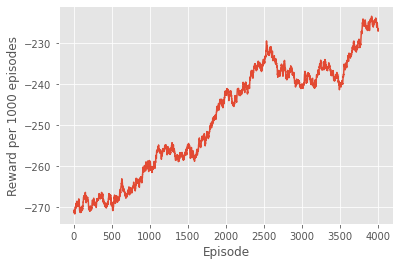

In [4]:
    # (code : https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.show.html)
    # Show a graph of the rewards/episodes 
    moving_avg = np.convolve(rewards_episode, np.ones((STOP_EVERY,))/STOP_EVERY, mode='valid')

    plt.plot([i for i in range(len(moving_avg))], moving_avg)
    plt.ylabel(f"Reward per {STOP_EVERY} episodes")
    plt.xlabel("Episode")
    plt.show()